In [ ]:
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, Bidirectional, Flatten
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import regularizers
import tensorflow.keras.utils as ku 
import numpy as np 

from tensorflow.keras.callbacks import EarlyStopping

import re
import numpy as np

from google.colab import files

In [ ]:
files.upload()
!ls

Saving bad_advices.txt to bad_advices (1).txt
'bad_advices (1).txt'   bad_advices.txt   sample_data


In [ ]:
tokenizer = Tokenizer(num_words=1000)

data = open('bad_advices.txt', encoding='Utf-8').read()
#Читаем текст
corpus = data.lower().split("\n")

In [ ]:
corpus[:10]

['григорий остер',
 '',
 '',
 'вредные советы',
 '',
 '',
 '',
 'книга для непослушных детей и их родителей',
 '',
 'послушным детям читать запрещается!']

In [ ]:
def clean_text(text):
    '''
    очистка текста
    на выходе очищеный текст
    
    '''
    if not isinstance(text, str):
        text = str(text)
    
    text = text.lower()
    text = text.strip('\n').strip('\r').strip('\t')
    text = re.sub("-\s\r\n\|-\s\r\n|\r\n", '', str(text))

    text = re.sub("[0-9]|[-—.,:;_%©«»?*!@#№$^•·&()]|[+=]|[[]|[]]|[/]|", '', text)
    text = re.sub(r"\r\n\t|\n|\\s|\r\t|\\n", ' ', text)
    text = re.sub(r'[\xad]|[\s+]', ' ', text.strip())
    
    
    return text

In [ ]:
for i in range(len(corpus)):
    corpus[i] = clean_text(corpus[i])

In [ ]:
corpus[:10]

['григорий остер',
 '',
 '',
 'вредные советы',
 '',
 '',
 '',
 'книга для непослушных детей и их родителей',
 '',
 'послушным детям читать запрещается']

In [ ]:
tokenizer.fit_on_texts(corpus)
total_words = len(tokenizer.word_index) + 1

input_sequences = []
for line in corpus:
    token_list = tokenizer.texts_to_sequences([line])[0]
    for i in range(1, len(token_list)):
        n_gram_sequence = token_list[:i+1]
        input_sequences.append(n_gram_sequence)

max_sequence_len = max([len(x) for x in input_sequences])
input_sequences = np.array(pad_sequences(input_sequences, maxlen=max_sequence_len, padding='pre'))

# create predictors and label
predictors, label = input_sequences[:,:-1],input_sequences[:,-1]

label = ku.to_categorical(label, num_classes=total_words)

In [ ]:
predictors.shape

(3502, 96)

In [ ]:
max_sequence_len

97

In [ ]:
tokenizer.index_word[5]

'на'

In [ ]:
tokenizer.word_index['дом']

1505

In [ ]:
input_sequences[:10,:]

array([[  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0, 753, 360],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,

In [ ]:
label.shape

(3502, 2938)

In [ ]:
callback = EarlyStopping(monitor='val_loss', patience=10) 

In [ ]:
max_sequence_len

97

In [ ]:
model = Sequential()
model.add(Embedding(total_words, 10, input_length=max_sequence_len-1))  
model.add(LSTM(10))
model.add(Dropout(0.2))
model.add(Dense(total_words/2, activation='relu', kernel_regularizer=regularizers.l2(0.01)))
model.add(Dense(total_words, activation='softmax'))

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 96, 10)            29380     
_________________________________________________________________
lstm (LSTM)                  (None, 10)                840       
_________________________________________________________________
dropout (Dropout)            (None, 10)                0         
_________________________________________________________________
dense (Dense)                (None, 1469)              16159     
_________________________________________________________________
dense_1 (Dense)              (None, 2938)              4318860   
Total params: 4,365,239
Trainable params: 4,365,239
Non-trainable params: 0
_________________________________________________________________
None


In [ ]:
history = model.fit(predictors, label, epochs=100, validation_split=0.2, callbacks=[callback], verbose=1)

Epoch 1/100
88/88 [==============================] - 7s 84ms/step - loss: 7.2501 - accuracy: 0.0436 - val_loss: 6.4585 - val_accuracy: 0.0271
Epoch 2/100
88/88 [==============================] - 7s 79ms/step - loss: 6.1877 - accuracy: 0.0443 - val_loss: 6.4144 - val_accuracy: 0.1041
Epoch 3/100
88/88 [==============================] - 7s 79ms/step - loss: 6.0873 - accuracy: 0.0464 - val_loss: 6.4712 - val_accuracy: 0.0271
Epoch 4/100
88/88 [==============================] - 7s 80ms/step - loss: 6.0583 - accuracy: 0.0378 - val_loss: 6.5215 - val_accuracy: 0.0271
Epoch 5/100
88/88 [==============================] - 7s 80ms/step - loss: 6.0426 - accuracy: 0.0443 - val_loss: 6.5470 - val_accuracy: 0.1041
Epoch 6/100
88/88 [==============================] - 7s 79ms/step - loss: 6.0267 - accuracy: 0.0439 - val_loss: 6.5194 - val_accuracy: 0.1041
Epoch 7/100
88/88 [==============================] - 7s 79ms/step - loss: 5.9906 - accuracy: 0.0461 - val_loss: 6.5404 - val_accuracy: 0.0271
Epoch 

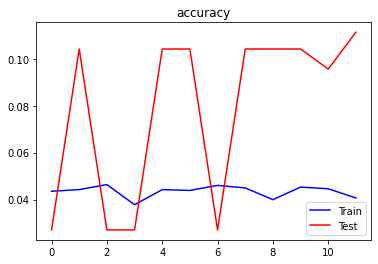

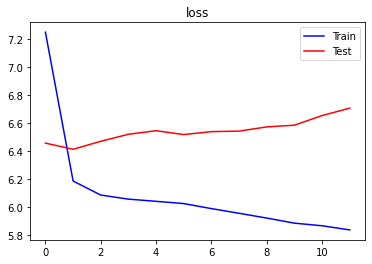

In [ ]:
import matplotlib.pyplot as plt
acc = history.history['accuracy']
acc_v = history.history['val_accuracy']
loss = history.history['loss']
loss_v = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'b', label='Train')
plt.plot(epochs, acc_v, 'r', label='Test')
plt.legend()
plt.title('accuracy')

plt.figure()

plt.plot(epochs, loss, 'b', label='Train')
plt.plot(epochs, loss_v, 'r', label='Test')
plt.title('loss')
plt.legend()

plt.show()

In [ ]:
# seed_text = "Мама мыла раму"
seed_text = "Непослушный ребенок пошел гулять"
next_words = 10
  
for _ in range(next_words):
	token_list = tokenizer.texts_to_sequences([seed_text])[0]
	print(token_list)
	token_list = pad_sequences([token_list], maxlen=max_sequence_len-1, padding='pre')
	predicted = model.predict_classes(token_list, verbose=0)
  #y_p=model.predict(token_list)
	output_word = ""
	y_p=model.predict(token_list)
	for word, index in tokenizer.word_index.items():
		if index == predicted:
			output_word = word
			break
	seed_text += " " + output_word
print(seed_text)

[222]
[222, 1]
[222, 1, 1]
[222, 1, 1, 1]
[222, 1, 1, 1, 1]
[222, 1, 1, 1, 1, 1]
[222, 1, 1, 1, 1, 1, 1]
[222, 1, 1, 1, 1, 1, 1, 1]
[222, 1, 1, 1, 1, 1, 1, 1, 1]
[222, 1, 1, 1, 1, 1, 1, 1, 1, 1]
Непослушный ребенок пошел гулять и и и и и и и и и и
